In [22]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
%matplotlib inline

In [3]:
data = pd.read_csv('../../../../data/titanic_train.csv', index_col='PassengerId')
print('Данных:'+str(data.shape[0]))
data.head(5)

Данных:891


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical

class FillNa(TransformerMixin, BaseEstimator):

    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        return X.interpolate(method='cubic').fillna(method='pad').dropna()
        
    
    
class DropOutlet(TransformerMixin, BaseEstimator):
    """
    Удаление выбросов, основываясь на правиле 3-х сигм (только для нормального распределения)
    """
        
    def fit(self, X: pd.DataFrame, y=None):
        """
        Получаем стандартное отклонение для каждого столбца и сохраняем их        
        """
        self.std = X.std()
        self.columns = self.std.index.values
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем все здачения, котоые находятся дальше 3-х стандартных отконений (сигма) от мат. ожидания случайной величины
        """
        X_cols = X[self.columns]
        return X[ (X_cols - X_cols.mean()).abs() <= 3*self.std ].dropna()

class PandasToNumpy(BaseEstimator):
    """
    Просто преобразует данные из DataFrame от pandas к матрице от numpy (ndarray)
    """
    
    def fit(self, X : pd.DataFrame = None, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values
    
class SparseToArray(TransformerMixin, BaseEstimator):
    """
    Класс преобразует sparse matrix в ndarray
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

class ModifyLabelEncoder(preprocessing.LabelEncoder):
    """
    Стандартный костыль для препроцессора LabelEncoder
    """
    
    def fit(self, X, y=None):
        return super().fit(X)
    
    def transform(self, X, y=None):
        print(1)
        return super().transform(X)
    
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)
    
    
class ExpandDims(TransformerMixin, BaseEstimator):
    """
    Увеличение на 1 рамерности массима в нужной оси
    """
    
    def __init__(self, axis):
        self.axis = axis
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.expand_dims(X, axis=self.axis)

Using TensorFlow backend.


In [5]:
x_data = data[data.columns[1:]].copy()
# Исключение некоторых не влияющих признаков
x_data = x_data.drop(['Ticket','Cabin','Name'],axis=1)
x_data = pd.get_dummies(x_data)

y_data = data[data.columns[0]].copy()

In [8]:
fill_na_pipe = pipeline.Pipeline([
    ('fill', FillNa()),
])

pipe_outlet = pipeline.Pipeline([
    ('fill_na', fill_na_pipe),
    ('drop_outlet', DropOutlet())
])

outletless_data_x = pipe_outlet.fit_transform(x_data)
#Синхронизация заполненных данных
outletless_data_y = y_data[ fill_na_pipe.fit_transform(y_data).index.isin(outletless_data_x.index)]
print('Кол-во векторов для обучения: '+str(outletless_data_y.shape[0]))

Кол-во векторов для обучения: 751


In [9]:
#Нормализация
pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preprocessing.MinMaxScaler())
])

pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
    ('expand_dims', ExpandDims(axis=1))
    #Разбитие на категории не имеет смысла, т.к у нас всего 2 категории
])

number_data_ready_x = pipe_x.fit_transform(outletless_data_x)
number_data_ready_y = pipe_y.fit_transform(outletless_data_y)
print(number_data_ready_x.shape, number_data_ready_y.shape)

(751, 10) (751, 1)


In [10]:
number_data_ready_x[:5,:], number_data_ready_y[:10]

(array([[ 1.        ,  0.37002318,  0.33333333,  0.        ,  0.04397492,
          0.        ,  1.        ,  0.        ,  0.        ,  1.        ],
        [ 0.        ,  0.5638622 ,  0.33333333,  0.        ,  0.4323693 ,
          1.        ,  0.        ,  1.        ,  0.        ,  0.        ],
        [ 1.        ,  0.41848293,  0.        ,  0.        ,  0.04806914,
          1.        ,  0.        ,  0.        ,  0.        ,  1.        ],
        [ 0.        ,  0.52751738,  0.33333333,  0.        ,  0.32207838,
          1.        ,  0.        ,  0.        ,  0.        ,  1.        ],
        [ 1.        ,  0.52751738,  0.        ,  0.        ,  0.04882733,
          0.        ,  1.        ,  0.        ,  0.        ,  1.        ]]),
 array([[0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1]], dtype=int64))

In [11]:
x_train = number_data_ready_x
y_train = number_data_ready_y
x_train.shape, y_train.shape

((751, 10), (751, 1))

In [12]:
from keras import layers, models, activations, optimizers, losses, metrics

In [13]:
model = models.Sequential(layers=[
    layers.Dense(10, activation='relu', input_dim=x_train.shape[1]),
    # С другой функцией активации (softmax) попросту не запускалось (не менялись значения)
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[metrics.binary_accuracy])

In [14]:
model.fit(x_train,
          y_train,
          verbose=2,
          epochs=50,
          batch_size=4)

Epoch 1/50
 - 0s - loss: 0.5912 - binary_accuracy: 0.6977
Epoch 2/50
 - 0s - loss: 0.5273 - binary_accuracy: 0.7763
Epoch 3/50
 - 0s - loss: 0.4987 - binary_accuracy: 0.7883
Epoch 4/50
 - 0s - loss: 0.4847 - binary_accuracy: 0.7883
Epoch 5/50
 - 0s - loss: 0.4772 - binary_accuracy: 0.7883
Epoch 6/50
 - 0s - loss: 0.4720 - binary_accuracy: 0.7883
Epoch 7/50
 - 0s - loss: 0.4671 - binary_accuracy: 0.7883
Epoch 8/50
 - 0s - loss: 0.4640 - binary_accuracy: 0.7883
Epoch 9/50
 - 0s - loss: 0.4614 - binary_accuracy: 0.7883
Epoch 10/50
 - 0s - loss: 0.4590 - binary_accuracy: 0.7870
Epoch 11/50
 - 0s - loss: 0.4566 - binary_accuracy: 0.7896
Epoch 12/50
 - 0s - loss: 0.4541 - binary_accuracy: 0.7883
Epoch 13/50
 - 0s - loss: 0.4530 - binary_accuracy: 0.7843
Epoch 14/50
 - 0s - loss: 0.4512 - binary_accuracy: 0.7883
Epoch 15/50
 - 0s - loss: 0.4487 - binary_accuracy: 0.7883
Epoch 16/50
 - 0s - loss: 0.4478 - binary_accuracy: 0.7909
Epoch 17/50
 - 0s - loss: 0.4458 - binary_accuracy: 0.7909
Epoch 

In [15]:
model.evaluate(x_train, y_train)

751/751 [==============================] - 0s 27us/step


[0.41479678985758245, 0.81624500689589075]

In [16]:
from keras import callbacks

In [17]:
xy_data = np.hstack( (number_data_ready_x, number_data_ready_y)).transpose((0,1))
np.random.shuffle(xy_data)
point_split = round(xy_data.shape[0] * 0.8)
train_data = xy_data[:point_split]
test_data = xy_data[point_split:]

In [18]:
x_train = train_data[:,:-1]
y_train = train_data[:,-1:]

x_test = test_data[:,:-1]
y_test = test_data[:,-1:]

In [19]:
def make_nn(input_len, output_len):
    model = models.Sequential(layers=[
        layers.Dense(10, activation=activations.relu, input_dim=input_len),
        layers.Dense(output_len, activation=activations.sigmoid)
    ])
    model.compile(optimizer='adam', loss=losses.binary_crossentropy, metrics=['accuracy'])
    return model

In [20]:
model = make_nn(x_train.shape[1], y_train.shape[1])

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=4,
    epochs=100,
    verbose=1,
    validation_data=(x_test,y_test),
    callbacks=[
        callbacks.History()
    ]
)

Train on 601 samples, validate on 150 samples
Epoch 1/100
601/601 [==============================] - 0s 486us/step - loss: 0.6995 - acc: 0.5258 - val_loss: 0.6509 - val_acc: 0.7667
Epoch 2/100
601/601 [==============================] - 0s 194us/step - loss: 0.6018 - acc: 0.7953 - val_loss: 0.5916 - val_acc: 0.7533
Epoch 3/100
601/601 [==============================] - 0s 187us/step - loss: 0.5547 - acc: 0.7970 - val_loss: 0.5557 - val_acc: 0.7533
Epoch 4/100
601/601 [==============================] - 0s 188us/step - loss: 0.5197 - acc: 0.7970 - val_loss: 0.5350 - val_acc: 0.7533
Epoch 5/100
601/601 [==============================] - 0s 193us/step - loss: 0.4975 - acc: 0.7970 - val_loss: 0.5213 - val_acc: 0.7533
Epoch 6/100
601/601 [==============================] - 0s 192us/step - loss: 0.4824 - acc: 0.7953 - val_loss: 0.5155 - val_acc: 0.7533
Epoch 7/100
601/601 [==============================] - 0s 202us/step - loss: 0.4738 - acc: 0.7970 - val_loss: 0.5055 - val_acc: 0.7533
Epoch 8/1

In [23]:
def show_learn_history(hist):
    plt.figure(0, figsize=(10,5))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('График ошибки')
    plt.ylabel('Значение')
    plt.xlabel('Эпоха')
    plt.legend(['Ошибка (train)', 'Ошибка (test)'])

    plt.figure(1, figsize=(10,5))
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('График точности')
    plt.ylabel('Значение')
    plt.xlabel('Эпоха')
    plt.legend(['Точность (train)', 'Точность (test)'])

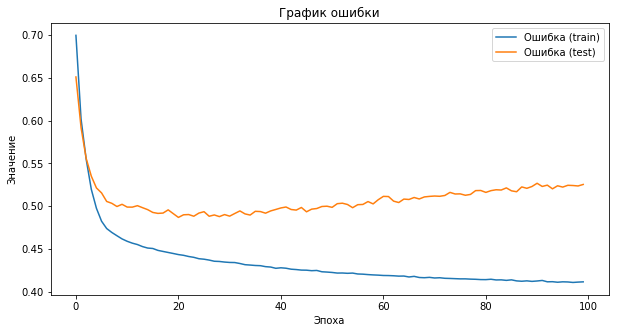

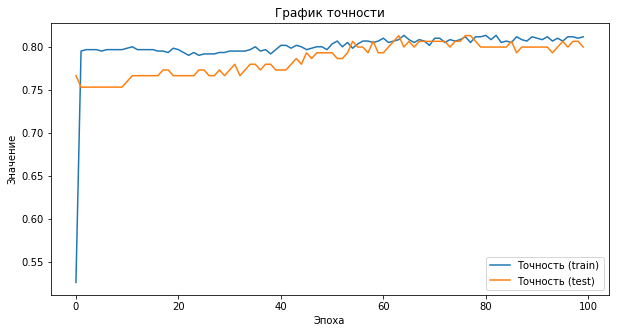

In [24]:
show_learn_history(history)

In [25]:
model = make_nn(number_data_ready_x.shape[1], number_data_ready_y.shape[1])

history = model.fit(
    x=number_data_ready_x,
    y=number_data_ready_y,
    batch_size=4,
    epochs=100,
    verbose=1,
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
    ]
)

Train on 600 samples, validate on 151 samples
Epoch 1/100
600/600 [==============================] - 0s 525us/step - loss: 0.7357 - acc: 0.4800 - val_loss: 0.6239 - val_acc: 0.6887
Epoch 2/100
600/600 [==============================] - 0s 193us/step - loss: 0.5839 - acc: 0.7517 - val_loss: 0.5214 - val_acc: 0.8013
Epoch 3/100
600/600 [==============================] - 0s 194us/step - loss: 0.5191 - acc: 0.7733 - val_loss: 0.4704 - val_acc: 0.8212
Epoch 4/100
600/600 [==============================] - 0s 189us/step - loss: 0.4898 - acc: 0.7833 - val_loss: 0.4451 - val_acc: 0.8146
Epoch 5/100
600/600 [==============================] - 0s 208us/step - loss: 0.4749 - acc: 0.7833 - val_loss: 0.4311 - val_acc: 0.8146
Epoch 6/100
600/600 [==============================] - 0s 206us/step - loss: 0.4684 - acc: 0.7833 - val_loss: 0.4233 - val_acc: 0.8212
Epoch 7/100
600/600 [==============================] - 0s 209us/step - loss: 0.4643 - acc: 0.7867 - val_loss: 0.4178 - val_acc: 0.8212
Epoch 8/1

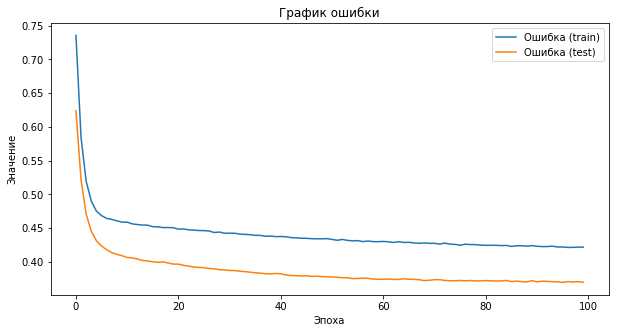

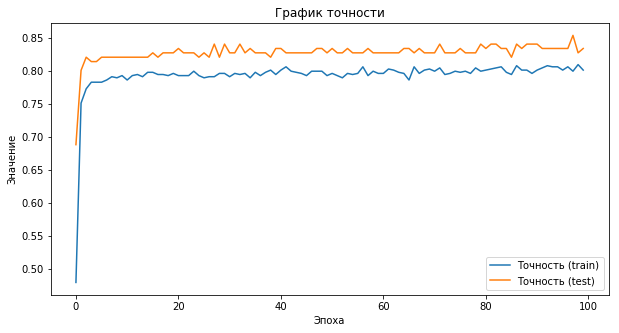

In [26]:
show_learn_history(history)

In [27]:
model = make_nn(number_data_ready_x.shape[1], number_data_ready_y.shape[1])

history = model.fit(
    x=number_data_ready_x,
    y=number_data_ready_y,
    batch_size=2,
    epochs=300,
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
            monitor='val_acc',
            mode='max',
            patience=50,
            min_delta=0.01
        )
    ]
)

Train on 600 samples, validate on 151 samples
Epoch 1/300
600/600 [==============================] - 0s 776us/step - loss: 0.6103 - acc: 0.7133 - val_loss: 0.5139 - val_acc: 0.8344
Epoch 2/300
600/600 [==============================] - 0s 402us/step - loss: 0.5170 - acc: 0.7883 - val_loss: 0.4507 - val_acc: 0.8212
Epoch 3/300
600/600 [==============================] - 0s 426us/step - loss: 0.4870 - acc: 0.7800 - val_loss: 0.4310 - val_acc: 0.8212
Epoch 4/300
600/600 [==============================] - 0s 388us/step - loss: 0.4783 - acc: 0.7900 - val_loss: 0.4215 - val_acc: 0.8212
Epoch 5/300
600/600 [==============================] - 0s 399us/step - loss: 0.4741 - acc: 0.7817 - val_loss: 0.4175 - val_acc: 0.8212
Epoch 6/300
600/600 [==============================] - 0s 391us/step - loss: 0.4703 - acc: 0.7867 - val_loss: 0.4138 - val_acc: 0.8212
Epoch 7/300
600/600 [==============================] - 0s 384us/step - loss: 0.4674 - acc: 0.7783 - val_loss: 0.4116 - val_acc: 0.8212
Epoch 8/3

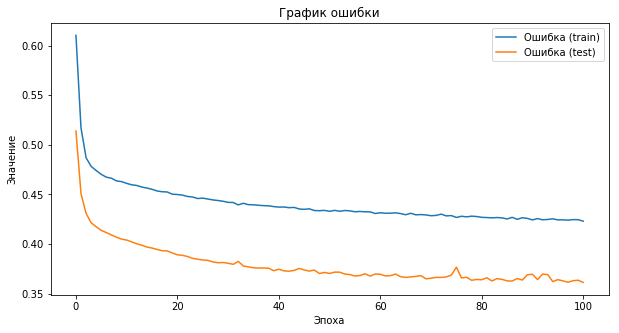

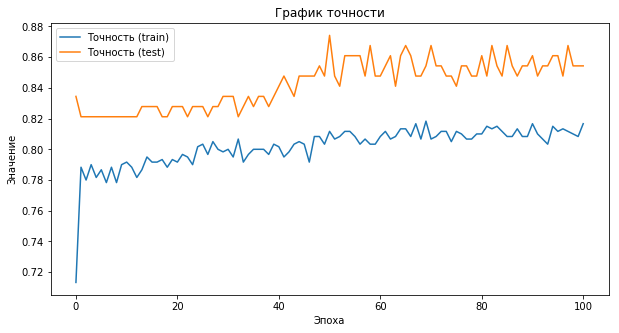

In [28]:
show_learn_history(history)

In [29]:
from pathlib import Path
from os import remove

In [36]:
file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{acc:.2f}_val_acc-{val_acc:.2f}.hdf5'

In [41]:
def make_save_points(name='save_points', file_name=file_name):
    checkpoints_dir = Path('./').joinpath('save_points')
    checkpoints_dir.mkdir(exist_ok=True)
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            remove(item)
    
    return str(checkpoints_dir.joinpath(file_name))

In [45]:
history = make_nn(x_train.shape[1], y_train.shape[1]).fit(
    x=x_train,
    y=y_train,
    batch_size=2,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
            monitor='val_acc',
            mode='max',
            patience=50,
            min_delta=0.01
        ),
        callbacks.ModelCheckpoint(
            'titanic.hdf5',
            monitor='val_acc',
            save_best_only=True,
            period=5,
            mode='max'
        )
    ]
)

Train on 480 samples, validate on 121 samples
Epoch 1/300
480/480 [==============================] - 0s 981us/step - loss: 0.5809 - acc: 0.7104 - val_loss: 0.5418 - val_acc: 0.7851
Epoch 2/300
480/480 [==============================] - 0s 399us/step - loss: 0.5051 - acc: 0.8104 - val_loss: 0.5020 - val_acc: 0.7603
Epoch 3/300
480/480 [==============================] - 0s 407us/step - loss: 0.4729 - acc: 0.8063 - val_loss: 0.4864 - val_acc: 0.7603
Epoch 4/300
480/480 [==============================] - 0s 409us/step - loss: 0.4581 - acc: 0.8063 - val_loss: 0.4794 - val_acc: 0.7603
Epoch 5/300
480/480 [==============================] - 0s 403us/step - loss: 0.4522 - acc: 0.8063 - val_loss: 0.4767 - val_acc: 0.7603
Epoch 6/300
480/480 [==============================] - 0s 413us/step - loss: 0.4497 - acc: 0.8063 - val_loss: 0.4744 - val_acc: 0.7603
Epoch 7/300
480/480 [==============================] - 0s 419us/step - loss: 0.4464 - acc: 0.8063 - val_loss: 0.4723 - val_acc: 0.7603
Epoch 8/3

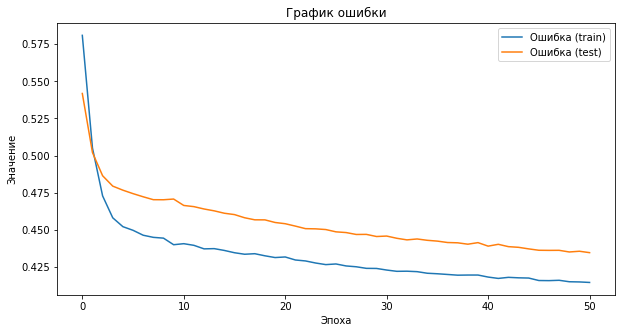

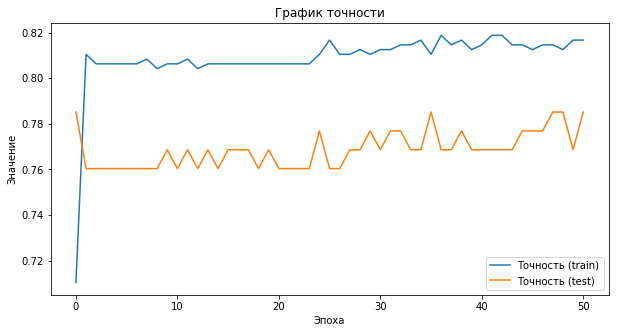

In [46]:
show_learn_history(history)

In [48]:
from keras.models import load_model

loaded_model = load_model('titanic.hdf5')
print('Точность предсказания на тренировочных данных '+str(loaded_model.evaluate(x_train, y_train)[1]))
print('Точность предсказания на тестовых данных '+str(loaded_model.evaluate(x_test, y_test)[1]))
predict = loaded_model.predict_classes(x_test)
predict

601/601 [==============================] - 0s 93us/step
Точность предсказания на тренировочных данных 0.805324458144
150/150 [==============================] - 0s 13us/step
Точность предсказания на тестовых данных 0.786666669846


array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [49]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf(xx, yy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

(751,)
(751, 2)


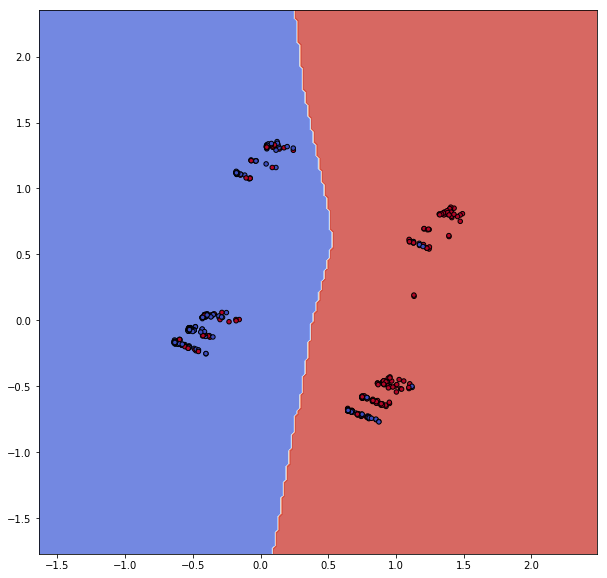

In [50]:
from sklearn.decomposition import PCA
pipe_y_mini = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
])


Y = pipe_y_mini.fit_transform(outletless_data_y)
X = number_data_ready_x

print(Y.shape)
pca = PCA(n_components=2)

_X = pca.fit_transform(X)
print(_X.shape)

clf_predict = lambda xx, yy: model.predict_classes(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

X0, X1 = _X[:, 0], _X[:, 1]
xx, yy = make_meshgrid(X0, X1)

clf_predict(xx, yy)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
plot_contours(ax, clf_predict, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')